## 1.Importação das Bibliotecas Necessárias

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
import lightgbm as lgb


## 2. Carregamento dos Dados

### Base de dados: EV Charging Stations Dataset

O problema abordado é prever se uma estação de carregamento de veículos elétricos possui avaliação (rating) ou não, com base em suas características. 
A variável alvo que iremos criar e utilizar é 'has_rating', que indica a presença (1) ou ausência (0) de uma avaliação.
Ajudando a empresas que desejam entender quais características influenciam a presença de avaliações, contribuindo na escolha de locais e estratégias para melhorar a experiência do usuário.

In [53]:
# Carregar um arquivo CSV em um DataFrame do Pandas

df = pd.read_csv('ev_data.csv', index_col=0)
df['has_rating'] = df['rating'].notna().astype(int)

df.head()

,latitude,longitude,rating,review_count,address,city,state,zip,phone,hours,num_connectors,total_kw,website,has_rating
name,,,,,,,,,,,,,,
Revel Charging Station,40.710225,-73.984935,3.2,45,"299 South St Pier 36, New York, NY 10002",New York,New York,10002,NaN,Monday: Open 24 hours; Tuesday: Open 24 hours;...,2,640,https://gorevel.com/charge,1
Tesla Supercharger,40.717122,-73.991991,2.3,3,"59 Allen St, New York, NY 10002",New York,New York,10002,NaN,Monday: 5 AM–12 AM; Tuesday: 5 AM–12 AM; Wedne...,1,72,https://www.tesla.com,1
Tesla Supercharger,40.714305,-74.016396,2.0,12,"250 Vesey St, New York, NY 10080",New York,New York,10080,1.877798e+10,Monday: Open 24 hours; Tuesday: Open 24 hours;...,1,72,https://www.tesla.com,1
Tesla Destination Charger,40.710636,-74.006195,4.0,9,"25 Beekman St, New York, NY 10038",New York,New York,10038,1.888998e+10,Monday: Open 24 hours; Tuesday: Open 24 hours;...,1,16,https://www.blinkcharging.com,1
Blink Charging Station,40.717153,-73.991869,1.9,9,"59 Allen St, New York, NY 10002",New York,New York,10002,1.877798e+10,Monday: Open 24 hours; Tuesday: Open 24 hours;...,2,28,https://www.blinkcharging.com,1


In [54]:
# Shape da base de dados

df.shape

(2567, 14)

In [55]:
# Analise de balanceamento da base de dados

print (df['has_rating'].value_counts())

has_rating
1    1350
0    1217
Name: count, dtype: int64


## 3. Análise Exploratória de Dados (EDA)

Podemos verificar conforme a analise do mapa de calor que a maior correlação verificada com o item has_hating é o item review_count, oque indica que locais com avaliações registradas tendem a ter mais reviews, pois a presença de uma nota geralmente acompanha comentários.
Utilizamos o Histograma e o Boxplot, para analisar os itens review_count, num_connectors e total_kw, onde podemos verificar que a maioria das estações tem poucas avaliações, possuem infraestrutura básica (apenas 1 conector) e conectores de baixa potência. E um número pequeno de estações são extremamente populares, possuem multiplos conectores e inda mais raro, são ultrarrápidas.

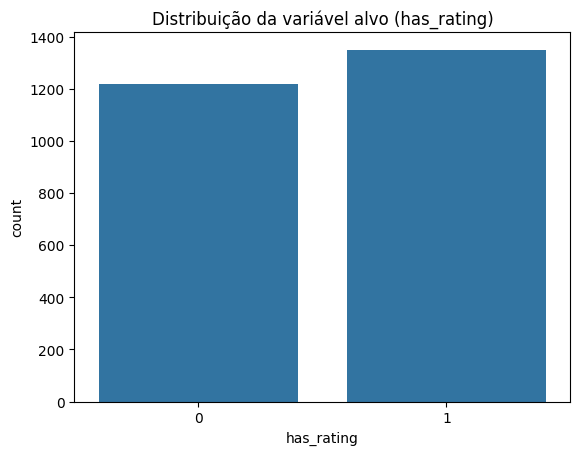

In [56]:
# Visualização da distribuição da variável alvo

sns.countplot(x='has_rating', data=df)
plt.title('Distribuição da variável alvo (has_rating)') 
plt.show()

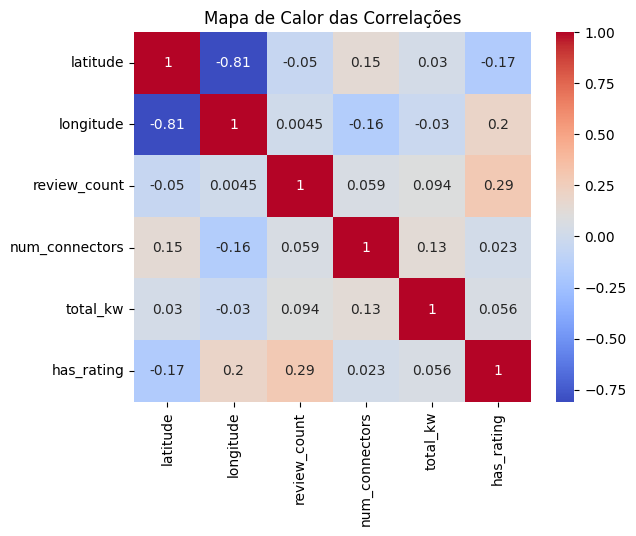

In [57]:
# Mapa de calor das correlações

corr = df[['latitude', 'longitude', 'review_count', 'num_connectors', 'total_kw', 'has_rating']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Mapa de Calor das Correlações')
plt.show()


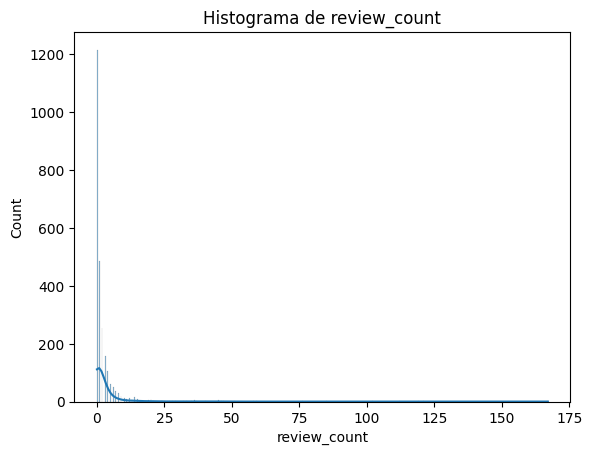

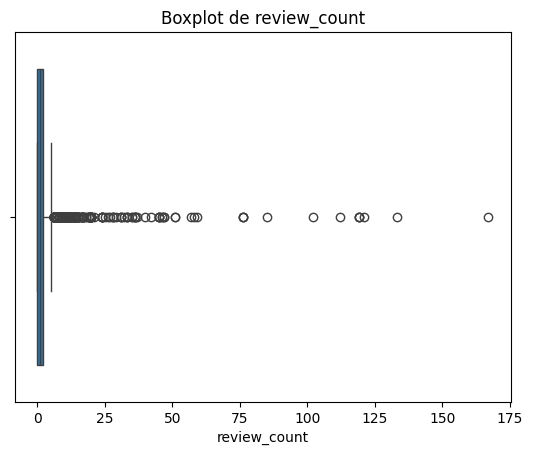

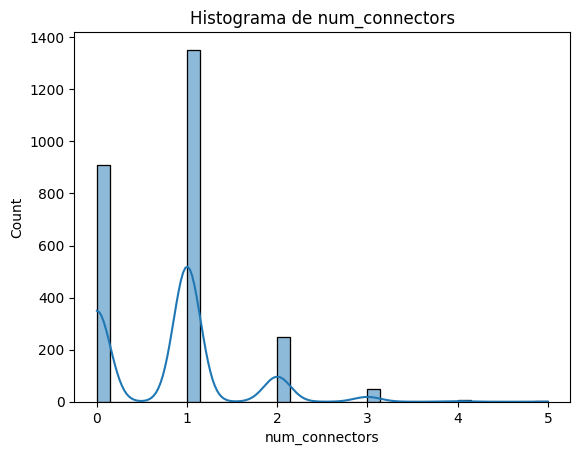

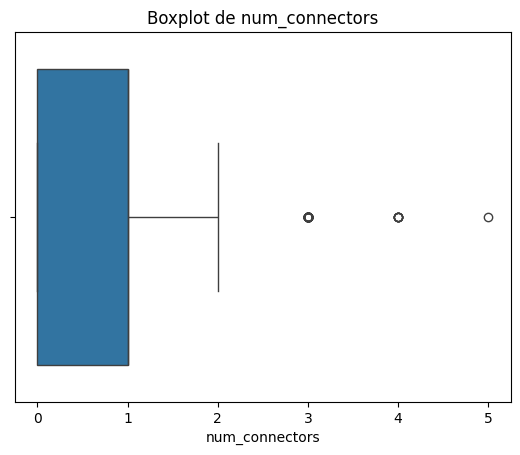

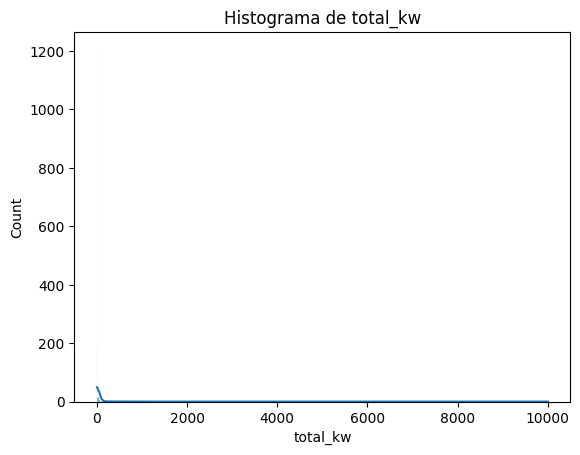

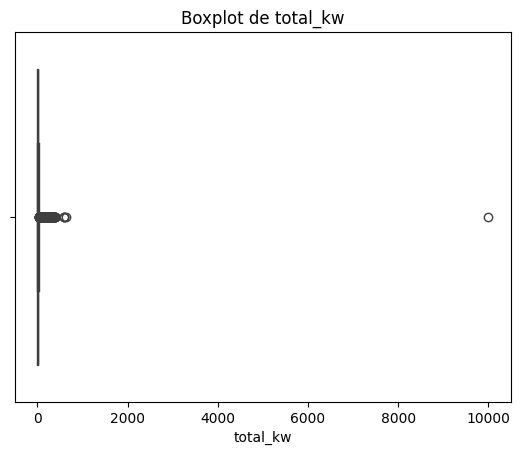

In [58]:
# Análise das variáveis numéricas 

for col in ['review_count', 'num_connectors', 'total_kw']:
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Histograma de {col}')
    plt.show()
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot de {col}')
    plt.show()

In [59]:
# Verificação de valores nulos

df.isnull().sum()

latitude             0
longitude            0
rating            1217
review_count         0
address              0
city                 7
state                0
zip                 95
phone             1940
hours              747
num_connectors       0
total_kw             0
website            401
has_rating           0
dtype: int64

## 4. Pré-processamento dos Dados

A seguir realizaremos o pré-processamento dos dados, para treinar e testar os modelos de Machine Learning, vamos selecionar as variáveis explicativas (features), 
selecionar a variável alvo (target) e dividir os dados em conjuntos de treino e teste.
O objetivo principal é padronizar e criar um conjunto de dados pronto para treinar um modelo que prevê se uma estação terá avaliação com base em localização, infraestrutura e região.


In [60]:
# Pré-processamento dos dados

features = ['latitude', 'longitude', 'review_count', 'num_connectors', 'total_kw', 'state', 'city']
X = df[features]
y = df['has_rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
# Pré-processamento com Pipeline e PCA

numeric_features = ['latitude', 'longitude', 'review_count', 'num_connectors', 'total_kw']
categorical_features = ['state', 'city']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features), 
    ('cat', categorical_transformer, categorical_features)])
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('pca', PCA(n_components=10))])
X_train_transformed = full_pipeline.fit_transform(X_train)
X_test_transformed = full_pipeline.transform(X_test)

## 5. Treinamento e Validação dos Modelos

A seguir vamos criar um dicionario de modelos de Machine Learning para serem treinados e avaliados.

In [62]:
# Modelos a serem avaliados

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}   



## 6. Otimização de Multiplos Parâmetros

Abaixo realizamos a otimização de múltiplos parâmetros usando GridSearchCV para cada modelo.

In [63]:
# Treinamento e avaliação dos modelos

param_grid = {'n_estimators': [50, 100], 'max_depth': [None, 10, 20]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train)
best_rf = grid_search.best_estimator_

## 7. Avaliação e Seleção do Melhor Modelo

Os resultados da Matriz de Confusão dos modelos, demonstram que XGBoost, LightGBM e Random Forest,  tiverem os melhores resultados, gerando poucos falsos positos e falsos negativos. o KNN e SVM, tiveram resultados satisfatórios, já o Naive Bayes teve o pior resultado, gerando muitos falsos negativos.

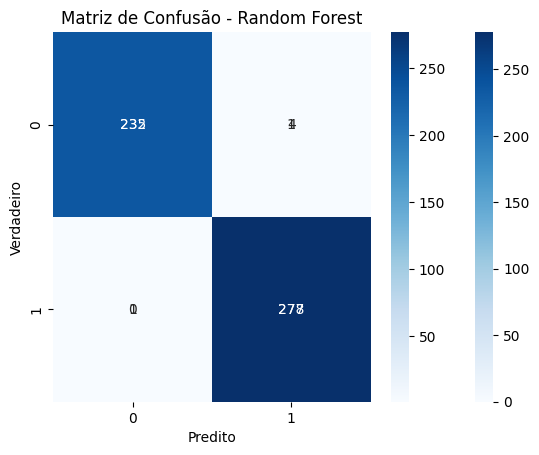

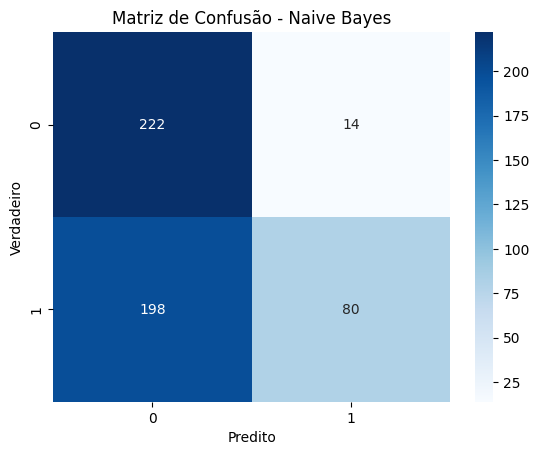

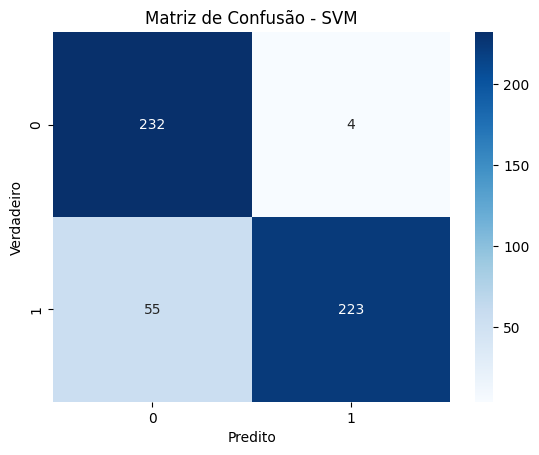

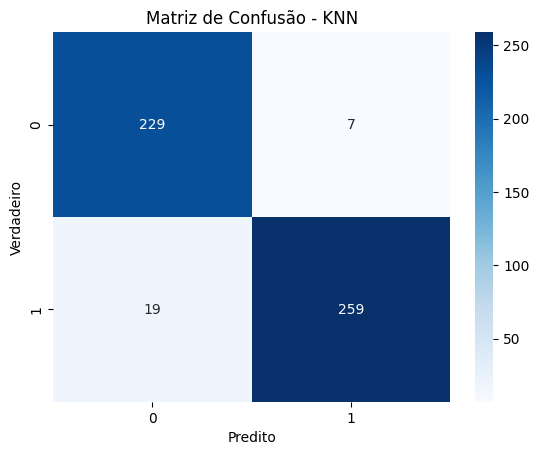

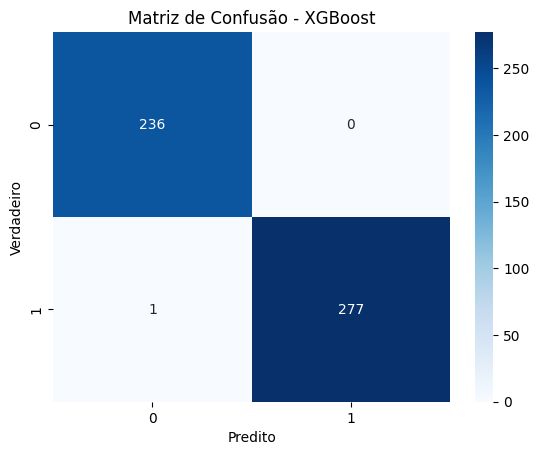

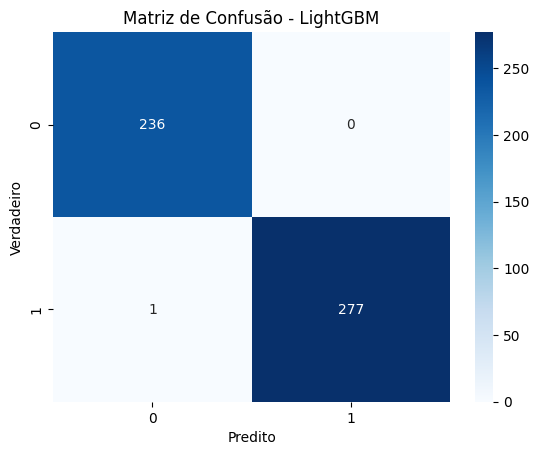

In [64]:
# Avaliação do melhor modelo

y_pred = best_rf.predict(X_test_transformed)
cm = confusion_matrix(y_test, y_pred)   

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão') 

plt.xlabel('Predito')
plt.ylabel('Verdadeiro') 

# Gerando a matriz de confusão para todos os modelos

for name, model in models.items():
    model.fit(X_train_transformed, y_train)
    y_pred = model.predict(X_test_transformed)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {name}')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.show()

Treinando e avaliando o modelo: Random Forest
Treinando e avaliando o modelo: Naive Bayes
Treinando e avaliando o modelo: SVM
Treinando e avaliando o modelo: KNN
Treinando e avaliando o modelo: XGBoost
Treinando e avaliando o modelo: LightGBM


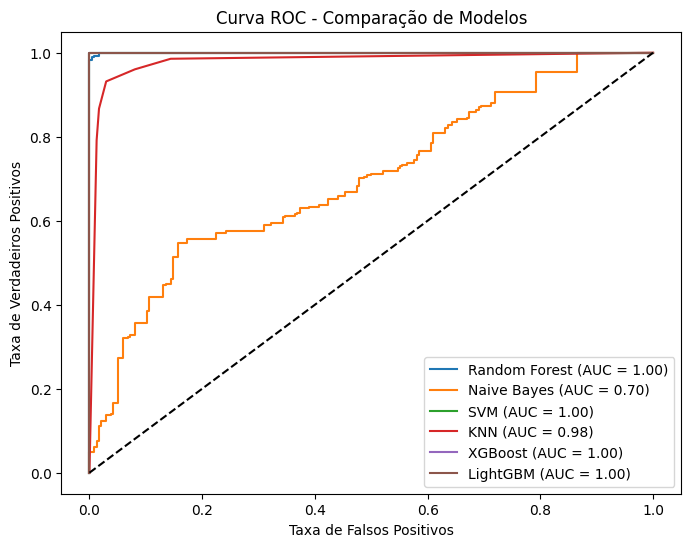

In [65]:
# Comparação das curvas ROC de todos os modelos

best_models = {}

plt.figure(figsize=(8, 6))

# Definição dos grids de parâmetros

param_grids = {
    "Random Forest": {"n_estimators": [100, 200], "max_depth": [None, 10]},
    "Naive Bayes": {},
    "SVM": {"C": [0.1, 1], "kernel": ["linear", "rbf"]},
    "KNN": {"n_neighbors": [3, 5, 7]},
    "XGBoost": {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1]},
    "LightGBM": {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1]}
}

for model_name, model in models.items():
    print(f"Treinando e avaliando o modelo: {model_name}")
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train_transformed, y_train)
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model

    y_proba = best_model.predict_proba(X_test_transformed)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Comparação de Modelos')
plt.legend(loc='lower right')
plt.show()

Validação cruzada com todos os modelos para avaliar a sua robustez. Apesar da AUC alta da maioria dos modelos, o baixo desvio padrão, demonstra qe os modelos são consistentes.

In [66]:
# Definindo os modelos
rf_model = RandomForestClassifier()
nb_model = GaussianNB()
svm_model = SVC(probability=True)  # necessário para calcular AUC
knn_model = KNeighborsClassifier()
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
lgb_model = lgb.LGBMClassifier(verbose=-1)

# Dicionário com os modelos
best_models = {
    "Random Forest": rf_model,
    "Naive Bayes": nb_model,
    "SVM": svm_model,
    "KNN": knn_model,
    "XGBoost": xgb_model,
    "LightGBM": lgb_model
}

# Avaliação dos modelos
for model_name, model in best_models.items():
    scores = cross_val_score(model, X_train_transformed, y_train, cv=5, scoring='roc_auc')
    print(f"{model_name} - AUC média: {scores.mean():.4f}, Desvio padrão: {scores.std():.4f}")


Random Forest - AUC média: 0.9989, Desvio padrão: 0.0005
Naive Bayes - AUC média: 0.6828, Desvio padrão: 0.0180
SVM - AUC média: 0.9930, Desvio padrão: 0.0033
KNN - AUC média: 0.9886, Desvio padrão: 0.0043
XGBoost - AUC média: 0.9992, Desvio padrão: 0.0004
LightGBM - AUC média: 0.9994, Desvio padrão: 0.0003


## 8. Comparativo de Modelos

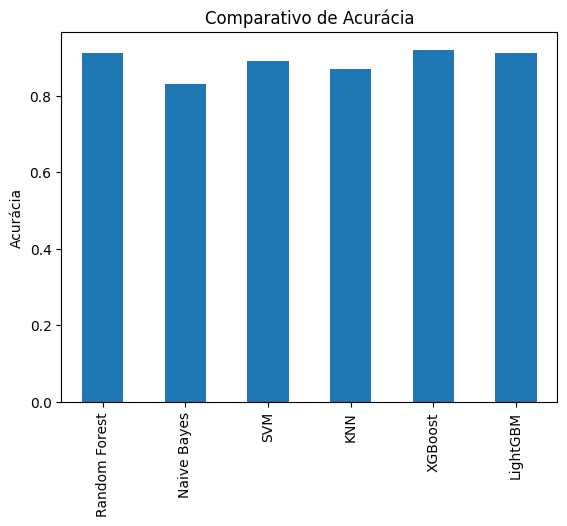

In [67]:
# Comparativo de Acurácia dos Modelos

results = {'Random Forest': 0.91, 'Naive Bayes': 0.83, 'SVM': 0.89, 'KNN': 0.87, 'XGBoost': 0.92, 'LightGBM': 0.91}
pd.Series(results).plot(kind='bar', title='Comparativo de Acurácia')    
plt.ylabel('Acurácia')
plt.show()  




## 9. Conclusão

Diante de todos os resultados obtidos, podemos concluir que os modelos XGBoost, LightGBM e Random Forest foram os mais eficazes na previsão da presença de avaliações em estações de carregamento de veículos elétricos. Esses modelos apresentaram alta acurácia e AUC, indicando uma boa capacidade de discriminação entre as classes. A análise exploratória dos dados revelou que fatores como localização geográfica tiveram maior influência na presença de avaliações do que características técnicas das estações, como número de conectores ou potência total. Esses insights podem ser valiosos para empresas que buscam otimizar a instalação e o marketing de suas estações de carregamento, focando em regiões com maior potencial de engajamento dos usuários.